In [1]:
from pathlib import Path

import polars as pl

from trade_analysis.ingress import load_trade_csv_v2
from trade_analysis.processing import compute_shares, compute_hhi, compute_product_weights
from trade_analysis.charts.pie import plot_pie
from trade_analysis.charts.bar import plot_bar
from trade_analysis.charts.share import plot_share_over_time
from trade_analysis.charts.hhi import plot_hhi_over_time
from trade_analysis.hypothesis_testing import screen_share_breaks, screen_hhi_breaks, compare_breakpoints
from trade_analysis.charts.trends import plot_segmented_trend, plot_hypothesis_summary

In [2]:
df = load_trade_csv_v2(Path("data/hs85.csv"))
result = compute_shares(df)
hhi = compute_hhi(result)
print(result)
print(hhi)

shape: (63_415, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ partner_c ┆ partner_n ┆ product_c ┆ product_n ┆ … ┆ yoy_chang ┆ ma_3y     ┆ is_signif ┆ was_sign │
│ ode       ┆ ame       ┆ ode       ┆ ame       ┆   ┆ e_percent ┆ ---       ┆ icant     ┆ ificant  │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│ str       ┆ str       ┆ i64       ┆ str       ┆   ┆ f64       ┆           ┆ bool      ┆ bool     │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ AD        ┆ Andorra   ┆ 85        ┆ ELECTRICA ┆ … ┆ null      ┆ null      ┆ false     ┆ null     │
│           ┆           ┆           ┆ L         ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ MACHINERY ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ AND       ┆   ┆           ┆      

In [19]:
weights = compute_product_weights(result, baseline_end=2019)
print(weights)

min_weight = 2.5
relevant_codes = weights.filter(pl.col("weight_pct") >= min_weight)["product_code"].to_list()
result_f = result.filter(pl.col("product_code").is_in(relevant_codes))
hhi_f = hhi.filter(pl.col("product_code").is_in(relevant_codes))
print(f"Subchapters >= {min_weight}% weight: {len(relevant_codes)} of {weights.height}")

shape: (46, 4)
┌──────────────┬─────────────────────────────────┬──────────────┬────────────┐
│ product_code ┆ product_name                    ┆ total_value  ┆ weight_pct │
│ ---          ┆ ---                             ┆ ---          ┆ ---        │
│ i64          ┆ str                             ┆ f64          ┆ f64        │
╞══════════════╪═════════════════════════════════╪══════════════╪════════════╡
│ 8517         ┆ Telephone sets, incl. telephon… ┆ 3.7484e11    ┆ 29.499248  │
│ 8542         ┆ Electronic integrated circuits… ┆ 1.2849e11    ┆ 10.111894  │
│ 8544         ┆ Insulated "incl. enamelled or … ┆ 7.3043e10    ┆ 5.748422   │
│ 8504         ┆ Electrical transformers, stati… ┆ 5.3746e10    ┆ 4.229773   │
│ 8528         ┆ Monitors and projectors, not i… ┆ 5.2018e10    ┆ 4.093781   │
│ …            ┆ …                               ┆ …            ┆ …          │
│ 8514         ┆ Industrial or laboratory elect… ┆ 1.5544e9     ┆ 0.122328   │
│ 8522         ┆ Parts and accessorie

In [4]:
product_codes = result["product_code"].unique().sort()
analysis_years = result["time_period"].unique().sort()

print("Product codes:", product_codes.to_list())
print("Years:", analysis_years.to_list())

Product codes: [85, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8509, 8510, 8511, 8512, 8513, 8514, 8515, 8516, 8517, 8518, 8519, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8528, 8529, 8530, 8531, 8532, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8544, 8545, 8546, 8547, 8548, 8549]
Years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]


In [5]:
# Line chart: China's share over time for each product
#for code in product_codes:
    #plot_share_over_time(result, code, partner_code="CN")

In [6]:
# Pie charts: partner breakdown for a specific product and year
#for year in analysis_years:
    #plot_pie(result, 8507, year, hhi_df=hhi)

In [7]:
# Bar charts: partner trade values for a specific product and year
#for year in analysis_years:
    #plot_bar(result, 8507, year, hhi_df=hhi)

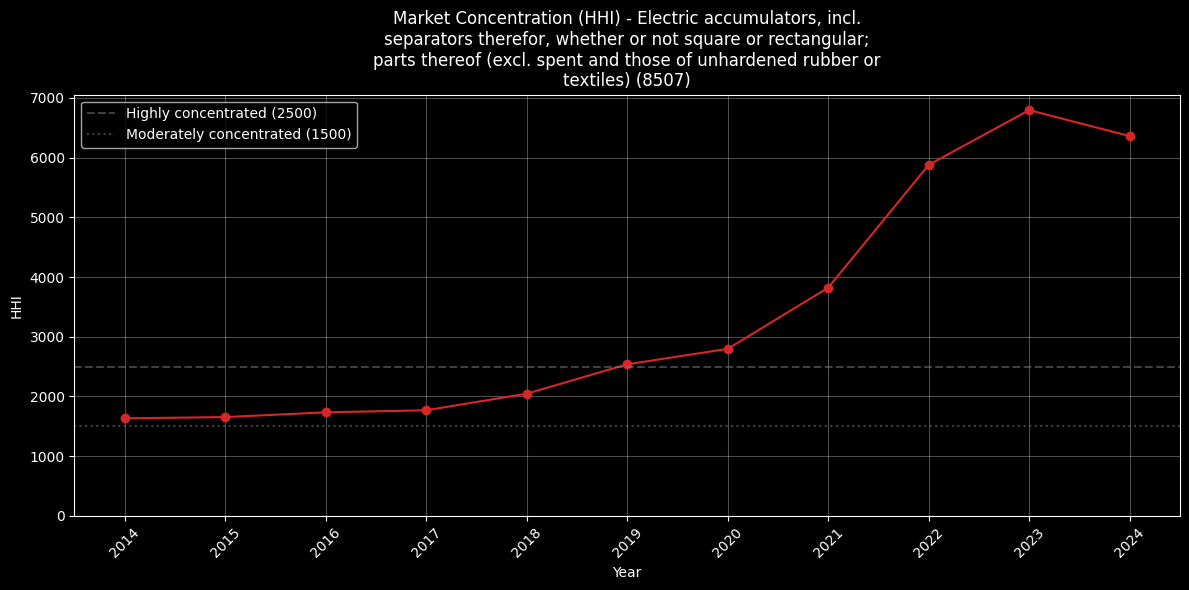

In [8]:
# HHI concentration over time for each product
code = 8507
name = result.filter(pl.col("product_code") == code)["product_name"][0]
plot_hhi_over_time(hhi, code, product_name=name)

## H1: China's import share — slope break screening at 2020

In [9]:
h1_2020 = screen_share_breaks(result_f, partner_code="CN", cutoff_year=2020, threshold=0.5)
print(h1_2020)

shape: (8, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ product_c ┆ product_n ┆ slope_bef ┆ slope_aft ┆ … ┆ level_aft ┆ level_cha ┆ direction ┆ is_meani │
│ ode       ┆ ame       ┆ ore       ┆ er        ┆   ┆ er        ┆ nge       ┆ ---       ┆ ngful    │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---      │
│ i64       ┆ str       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆           ┆ bool     │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 8517      ┆ Telephone ┆ 1.2097    ┆ -2.5135   ┆ … ┆ 64.19     ┆ 3.21      ┆ declining ┆ true     │
│           ┆ sets,     ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ incl.     ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ telephon… ┆           ┆           ┆   ┆           ┆           

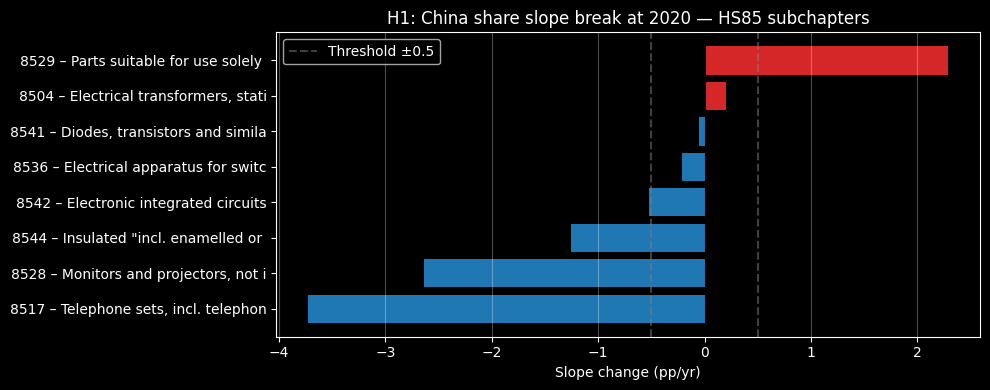

In [10]:
plot_hypothesis_summary(
    h1_2020,
    metric_label="Slope change (pp/yr)",
    title="H1: China share slope break at 2020 — HS85 subchapters",
    threshold=0.5,
)

## H2: HHI concentration — slope break screening at 2020

In [11]:
h2_2020 = screen_hhi_breaks(hhi_f, cutoff_year=2020, threshold=50)
print(h2_2020)

shape: (8, 9)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ product_c ┆ slope_bef ┆ slope_aft ┆ slope_cha ┆ … ┆ level_aft ┆ level_cha ┆ direction ┆ is_meani │
│ ode       ┆ ore       ┆ er        ┆ nge       ┆   ┆ er        ┆ nge       ┆ ---       ┆ ngful    │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---      │
│ i64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆           ┆ bool     │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 8517      ┆ 143.45    ┆ -275.11   ┆ -418.56   ┆ … ┆ 4354.21   ┆ 328.87    ┆ declining ┆ true     │
│ 8528      ┆ 193.16    ┆ -97.91    ┆ -291.07   ┆ … ┆ 5176.92   ┆ 1216.85   ┆ declining ┆ true     │
│ 8542      ┆ 47.65     ┆ -12.26    ┆ -59.91    ┆ … ┆ 1250.95   ┆ 43.63     ┆ declining ┆ true     │
│ 8544      ┆ 6.9       ┆ -9.96     ┆ -16.85    ┆ … ┆ 1082.21   ┆ 32.55     ┆

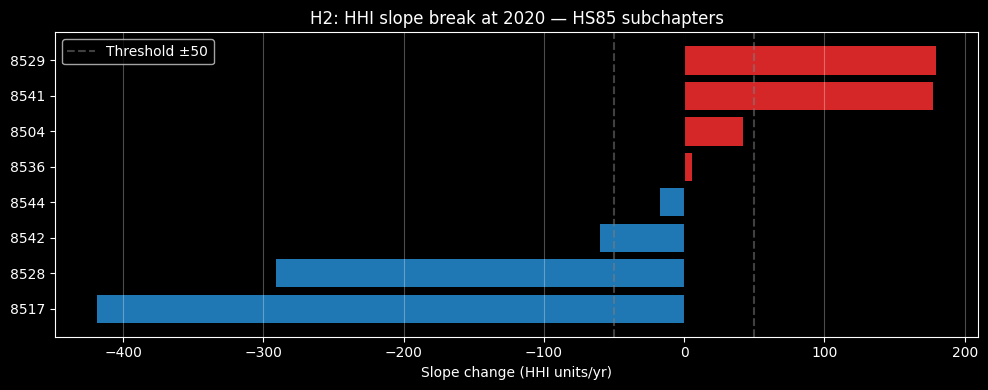

In [12]:
plot_hypothesis_summary(
    h2_2020,
    metric_label="Slope change (HHI units/yr)",
    title="H2: HHI slope break at 2020 — HS85 subchapters",
    threshold=50,
)

## H3: Comparing breakpoints — is the 2022 break stronger than 2020?

In [13]:
h3 = compare_breakpoints(result_f, hhi_f, partner_code="CN")
print(h3)

shape: (8, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ product_co ┆ product_na ┆ share_slop ┆ share_slo ┆ share_str ┆ hhi_slope ┆ hhi_slope ┆ hhi_stron │
│ de         ┆ me         ┆ e_chg_2020 ┆ pe_chg_20 ┆ onger_202 ┆ _chg_2020 ┆ _chg_2022 ┆ ger_2022  │
│ ---        ┆ ---        ┆ ---        ┆ 22        ┆ 2         ┆ ---       ┆ ---       ┆ ---       │
│ i64        ┆ str        ┆ f64        ┆ ---       ┆ ---       ┆ f64       ┆ f64       ┆ bool      │
│            ┆            ┆            ┆ f64       ┆ bool      ┆           ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 8504       ┆ Electrical ┆ 0.2065     ┆ -4.6634   ┆ true      ┆ 41.81     ┆ -497.59   ┆ true      │
│            ┆ transforme ┆            ┆           ┆           ┆           ┆           ┆           │
│            ┆ rs, stati… ┆            ┆           ┆           ┆           ┆ 

In [14]:
print("Share: stronger break at 2022 in", h3.filter(pl.col("share_stronger_2022")).height, "of", h3.height, "products")
print("HHI:   stronger break at 2022 in", h3.filter(pl.col("hhi_stronger_2022")).height, "of", h3.height, "products")

Share: stronger break at 2022 in 8 of 8 products
HHI:   stronger break at 2022 in 7 of 8 products


## Segmented trend — example product

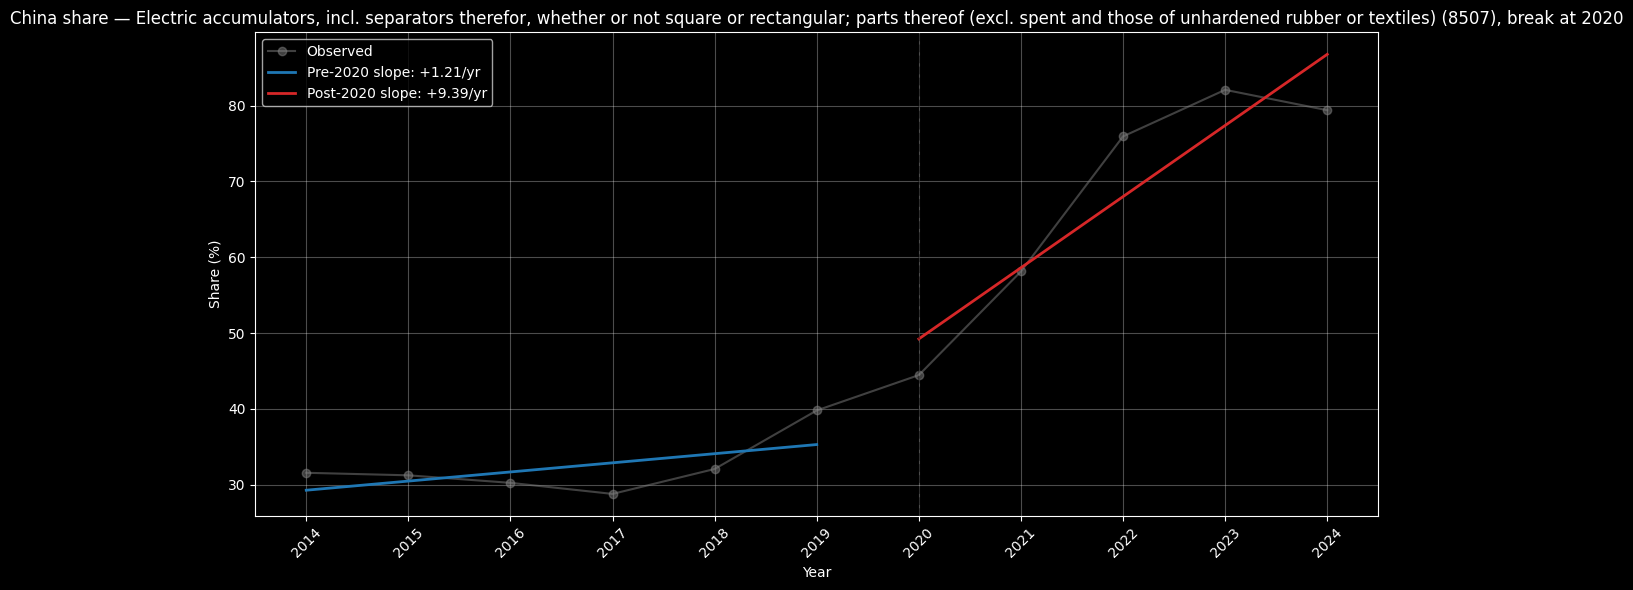

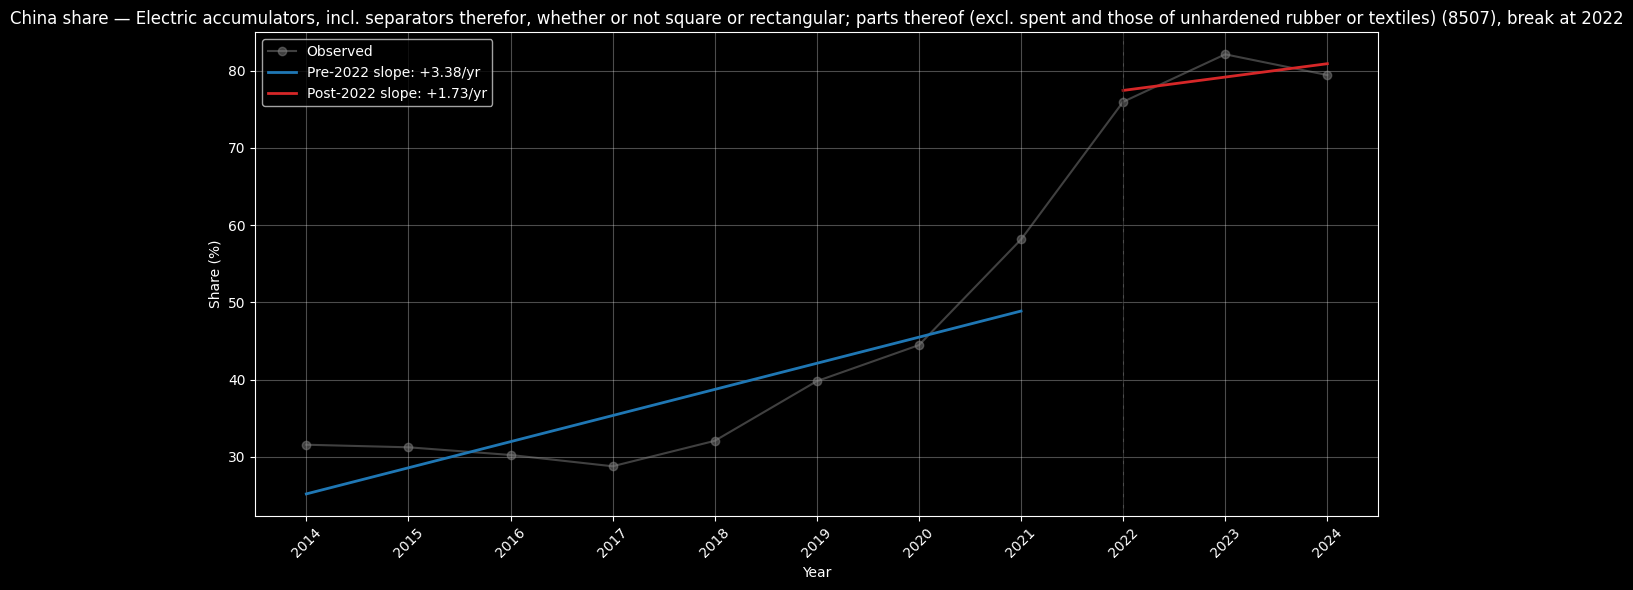

In [15]:
# Segmented trend for China's share in a specific product
example_code = 8507
partner_data = (
    result
    .filter((pl.col("product_code") == example_code) & (pl.col("partner_code") == "CN"))
    .sort("time_period")
)
product_name = partner_data["product_name"][0]

plot_segmented_trend(
    years=partner_data["time_period"].to_list(),
    values=(partner_data["share"] * 100).to_list(),
    cutoff_year=2020,
    title=f"China share — {product_name} ({example_code}), break at 2020",
    ylabel="Share (%)",
)

plot_segmented_trend(
    years=partner_data["time_period"].to_list(),
    values=(partner_data["share"] * 100).to_list(),
    cutoff_year=2022,
    title=f"China share — {product_name} ({example_code}), break at 2022",
    ylabel="Share (%)",
)

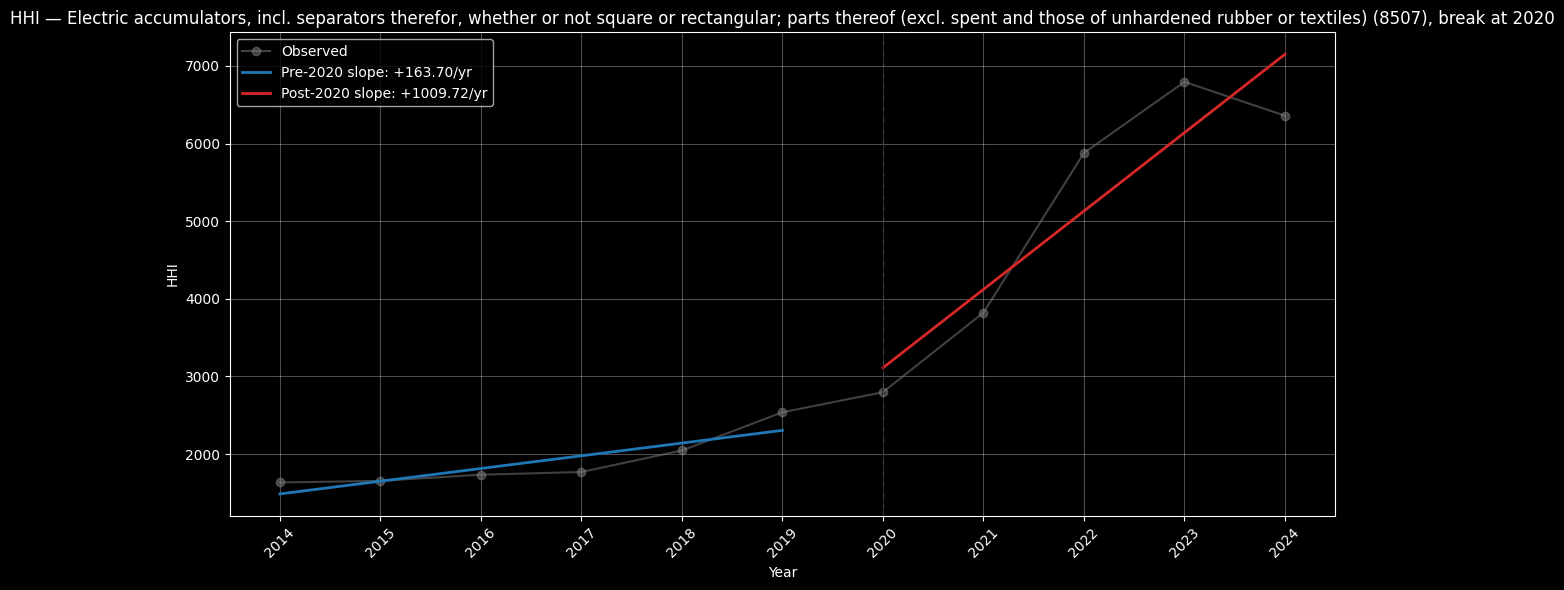

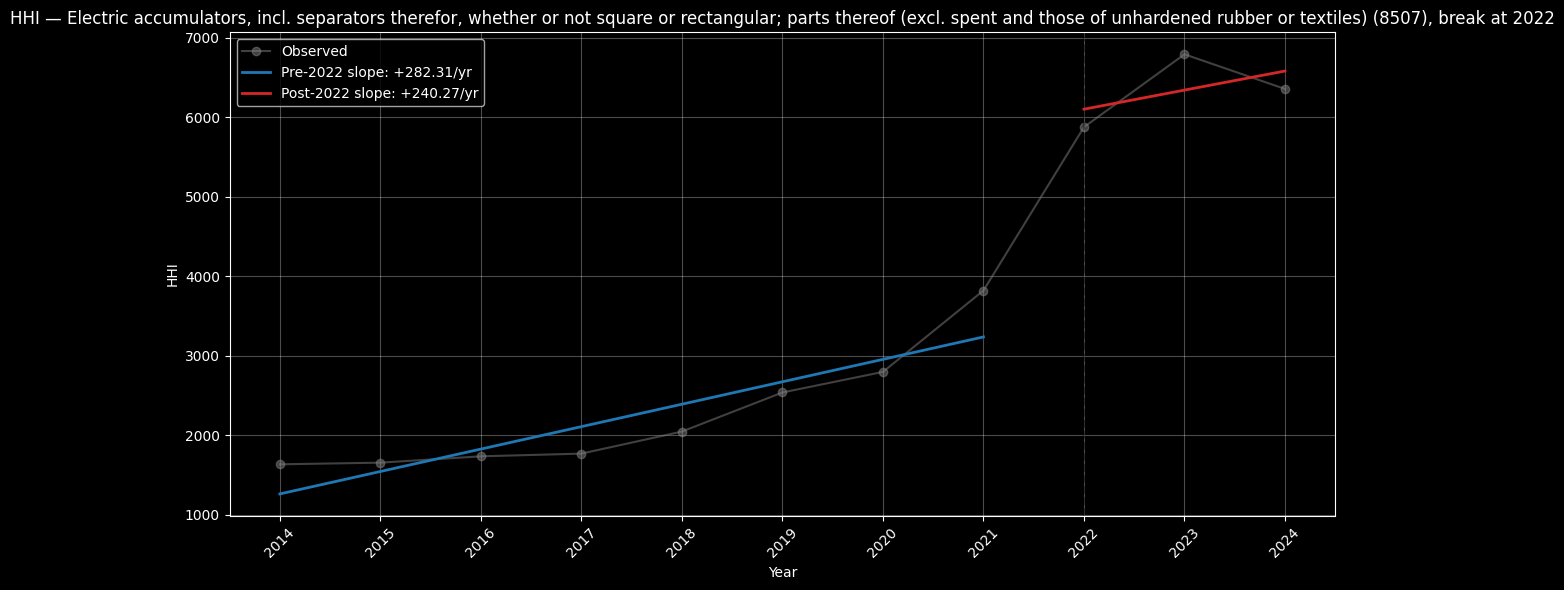

In [16]:
# Segmented trend for HHI of the same product
hhi_data = hhi.filter(pl.col("product_code") == example_code).sort("time_period")

plot_segmented_trend(
    years=hhi_data["time_period"].to_list(),
    values=hhi_data["hhi"].to_list(),
    cutoff_year=2020,
    title=f"HHI — {product_name} ({example_code}), break at 2020",
    ylabel="HHI",
)

plot_segmented_trend(
    years=hhi_data["time_period"].to_list(),
    values=hhi_data["hhi"].to_list(),
    cutoff_year=2022,
    title=f"HHI — {product_name} ({example_code}), break at 2022",
    ylabel="HHI",
)